# Opening images in Keras
Todo:
 - Change from Pillow to rasterio to read image
 - 

Sources:
    - https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a
    - https://stackoverflow.com/questions/46493419/use-a-generator-for-keras-model-fit-generator
    - https://stackoverflow.com/questions/50195967/how-can-i-create-a-4d-numpy-array-from-images
    - https://www.google.com/search?client=firefox-b-ab&q=keras+make+image+generator
 

In [1]:
from PIL import Image

import keras
from PIL import Image

import imageio
import random
import scipy
import numpy as np

import rasterio
import numpy as np

import pandas
import geopandas

Using TensorFlow backend.


## Variables

In [2]:
image_dir_path = '../Sorted_tiles/'       # Path to images

## Read imagelabels

In [3]:
import pandas as pd
labelfile = pd.read_csv('../Qgis/labeled_tiles.csv')
labelfile.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0,stripe_merged_2_01_31.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,stripe_merged_2_01_32.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,stripe_merged_2_01_33.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,stripe_merged_2_01_34.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,stripe_merged_2_01_35.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1


In [4]:
labelfile.describe()

,ID,LIVSM1,LIVSM2,1,2,3,4,5,6,7,8,9,10,11,12,99
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.0,551.0,551.000000,551.000000,551.0,551.0,551.0,551.0,551.0,551.0,551.00000
mean,275.000000,91.228675,91.310345,0.023593,0.023593,0.0,0.0,0.058076,0.058076,0.0,0.0,0.0,0.0,0.0,0.0,0.91833
std,159.204271,26.088214,25.814159,0.151917,0.151917,0.0,0.0,0.234100,0.234100,0.0,0.0,0.0,0.0,0.0,0.0,0.27411
min,0.000000,1.000000,2.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
25%,137.500000,99.000000,99.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
50%,275.000000,99.000000,99.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
75%,412.500000,99.000000,99.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.00000
max,550.000000,99.000000,99.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.00000


### Balance classes

In [5]:
# Stratified sample of the classes to get a balanced dataset with the same number of classes to train on.
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
# https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas

# Maximum number of elements in each class. If the classe have less than max every sample is included.
clasnumber_of_samples = 20

labelfile_balanced = labelfile.groupby(['LIVSM1'], group_keys=False).apply(lambda x: x.sample(min(len(x), clasnumber_of_samples))).reset_index(drop=True)
labelfile_balanced.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
0,484,stripe_merged_2_17_48.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0
1,342,stripe_merged_2_14_23.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0
2,235,stripe_merged_2_11_21.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0
3,167,stripe_merged_2_09_20.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0
4,270,stripe_merged_2_12_22.tif,1,2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,1,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Size of classes
labelfile_balanced_counted = labelfile_balanced.groupby('mult_bin_labels')['ID'].nunique()
labelfile_balanced_counted

mult_bin_labels
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]    20
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]    20
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    13
Name: ID, dtype: int64

## Homemade image data generator

In [7]:
def flip_vertical(image):
    return np.flipud(image)

def flip_horizontal(image):
    return np.fliplr(image)

def rotate_90(image):
    return np.rot90(image, k=1)

def rotate_180(image):
    return np.rot90(image, k=2)

def rotate_270(image):
    return np.rot90(image, k=3)


#def rotate_n_deg(image):
#    # Rotates the image a random amount. Fills the space with a reflection of the image. Kva blir best her? Heller bruke rot90?
#    rot = random.randrange(-180,180,30)
#    rot_image = scipy.ndimage.interpolation.rotate(image, rot,axes=(1, 0), reshape=False, output=None, order=3, mode='reflect', cval=0.0, prefilter=True)
#    return rot_image


def random_image_flip_rotation(image):
    # This function rotates or flips the image randomly using one of five functions. 
    # This function can also do nothing to the image. 1/6 chanche.
    # Returns a image

    randint = np.random.randint(low=1, high=6)
    modified_image = 0
    
    if randint == 1:
        modified_image = flip_vertical(image)
        
    elif randint == 2:
        modified_image = flip_horizontal(image)

    elif randint == 3:
        modified_image = rotate_90(image)
        
    elif randint == 4:
        modified_image = rotate_180(image)
        
    elif randint == 5:
        modified_image = rotate_270(image)

    else:
        modified_image = image
        
    return modified_image

A = np.array([[1, 2, 3], [4, 5, 6], [7,8,9]])
print(A)
print(flip_vertical(A))
print(flip_horizontal(A))
print(rotate_90(A))
print(rotate_180(A))
print(rotate_270(A))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[7 8 9]
 [4 5 6]
 [1 2 3]]
[[3 2 1]
 [6 5 4]
 [9 8 7]]
[[3 6 9]
 [2 5 8]
 [1 4 7]]
[[9 8 7]
 [6 5 4]
 [3 2 1]]
[[7 4 1]
 [8 5 2]
 [9 6 3]]


In [8]:
def get_input(path):
    
    img = imageio.imread(path)
    
    return(img)


def image_generator(image_path, label_file):
    # image_path: string where the images are placed.
    # label_file: csv file with labels and filenames.
    
    while True:
        batch_input = []
        batch_x = 0
        
        # Samples the file for a image, removes index so it can be used as loc[0]
        label_sample = label_file.sample().reset_index(drop=True)
        
        # Creates the file paths for the image
        image_sample_path = image_path + label_sample['Tile_name'].item()

        # Reads in each image as array, performs argumentation on each image
        input_raw = get_input(image_sample_path)
        input_permutated = random_image_flip_rotation(input_raw)
        
        # Reshape model to (n*k*3)
        #input_permutated = np.reshape(input_permutated, (632,625,3))
        from sklearn.decomposition import PCA
        pca = PCA(3)
        input_permutated = input_permutated.reshape(-1, 474)
        input_permutated = pca.fit_transform(input_permutated)
        input_permutated = input_permutated.reshape(50,50, 3)
        
        # Add a new dimention to the array because Keras wants it this way?
        input_new_dim = np.expand_dims(input_permutated, axis=0)

        
        # Set a label by using the tile name. This line first finds the rowdata for 
        # a spesific tile and gives it out as a dataframe. Then the .iloc function 
        # finds the values of the colums 1 up to 99 and give them out as a list(list in a list). 
        label = label_sample.loc[0, ['1','2','3','4','5','6','7','8','9','10','11','12','99']].values
        
        # Place the labels inside a list in a list because Keras wants it this way??
        label = [[label]]

        yield(input_new_dim, label)

In [9]:
test_generated_images = image_generator(image_dir_path, labelfile_balanced)
generert = next(test_generated_images)
print(generert)
#print(next(test_generated_images))
print(np.shape(generert[0]))
print(generert[1])

/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functiona

(array([[[[-0.04860554,  0.0123365 , -0.00170984],
         [-0.05999059, -0.00148404,  0.00502425],
         [-0.03395687,  0.00321575, -0.00218779],
         ...,
         [ 0.03213587, -0.00751878, -0.00979679],
         [-0.00830686, -0.00459867, -0.00180557],
         [-0.02424038, -0.00467964,  0.00756002]],

        [[-0.0720896 ,  0.02502047, -0.00061396],
         [-0.03621103,  0.00262271, -0.00148954],
         [-0.03699043,  0.01166123, -0.00411452],
         ...,
         [-0.00378271, -0.01601455,  0.0006087 ],
         [ 0.00685258, -0.01781014, -0.00100702],
         [ 0.01524073, -0.00187244, -0.00195559]],

        [[-0.03194704,  0.02362733,  0.00620418],
         [-0.03980976, -0.00579244,  0.01710093],
         [-0.01710483,  0.00375253,  0.00916189],
         ...,
         [ 0.0373477 , -0.02129522,  0.00393455],
         [ 0.04358029, -0.01456823,  0.00045837],
         [ 0.01560294, -0.00325767,  0.00471162]],

        ...,

        [[-0.03568701,  0.01929437,  

## Keras model

In [458]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization

model = Sequential()
model.add(BatchNormalization(input_shape=(50,50,3)))
model.add(Conv2D(64, (5, 5), padding='valid', activation='relu'))
#model.add(Conv2D(256, (3, 3), padding='valid', activation='relu', input_shape=(50,50,474)))
model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), padding='valid', activation='relu'))

model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), padding='valid', activation='relu'))

model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))


model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=["categorical_accuracy",
                        "sparse_categorical_accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 50, 50, 3)         12        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        4864      
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 42, 42, 32)        51232     
_________________________________________________________________
batch_normalization_9 (Batch (None, 42, 42, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 38, 38, 32)        25632     
_________________________________________________________________
batch_normalization_10 (Batc (None, 38, 38, 32)        128       
__________

In [456]:
from keras.applications.densenet import DenseNet201

model = Sequential()
# create the base pre-trained model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(50, 50, 3))


for layer in base_model.layers:
    if layer.name != 'BatchNormalization':
        layer.trainable = False
        #print(layer.name)


# add a global spatial average pooling layer
model.add(base_model)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=["categorical_accuracy",
                        "sparse_categorical_accuracy"])
model.summary()

5

In [459]:
model.fit_generator(
        image_generator(image_dir_path, labelfile_balanced),
        steps_per_epoch=64,
        epochs=20)

Epoch 1/20
64/64 [==============================] - 15s 239ms/step - loss: 0.3795 - categorical_accuracy: 0.1562 - sparse_categorical_accuracy: 0.0709
Epoch 2/20
64/64 [==============================] - 8s 126ms/step - loss: 0.2597 - categorical_accuracy: 0.2656 - sparse_categorical_accuracy: 0.0036
Epoch 3/20
64/64 [==============================] - 8s 127ms/step - loss: 0.2697 - categorical_accuracy: 0.2656 - sparse_categorical_accuracy: 0.0168
Epoch 4/20
64/64 [==============================] - 8s 131ms/step - loss: 0.2590 - categorical_accuracy: 0.3594 - sparse_categorical_accuracy: 0.0180
Epoch 5/20
64/64 [==============================] - 9s 140ms/step - loss: 0.2585 - categorical_accuracy: 0.2500 - sparse_categorical_accuracy: 0.0865
Epoch 6/20
64/64 [==============================] - 9s 146ms/step - loss: 0.2170 - categorical_accuracy: 0.4219 - sparse_categorical_accuracy: 0.0445
Epoch 7/20
64/64 [==============================] - 10s 153ms/step - loss: 0.1748 - categorical_acc

In [468]:
test_image_predict = labelfile_balanced.sample()
test_image_predict.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
27,60,stripe_merged_2_05_30.tif,5,6,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]",0,0,0,0,1,1,0,0,0,0,0,0,0


In [469]:
nn = model.predict_generator(
        image_generator(image_dir_path, test_image_predict),
        steps=1)
print(np.round(nn,2))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [470]:
sum(nn[0])

1.0002011667658406

## Save model

In [32]:
model.save('../Models/simple_model_rot90_0504.h5')

## Create predictions

In [463]:
predicted_classes_gdf = labelfile.copy()
predicted_classes_gdf.head()

,ID,Tile_name,LIVSM1,LIVSM2,mult_bin_labels,1,2,3,4,5,6,7,8,9,10,11,12,99
0,0,stripe_merged_2_01_31.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,stripe_merged_2_01_32.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,stripe_merged_2_01_33.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,stripe_merged_2_01_34.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,stripe_merged_2_01_35.tif,99,99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,0,0,0,1


In [464]:
predicted_classes_gdf = geopandas.GeoDataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12','99'])
predicted_classes_gdf

,1,2,3,4,5,6,7,8,9,10,11,12,99


In [465]:
pp = pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12','99'], data=test_image_predict)
pp

,1,2,3,4,5,6,7,8,9,10,11,12,99
43,0,0,0,0,0,0,0,0,0,0,0,0,1


In [466]:
%time
stored_labels = []

for num_tile, tile in labelfile.iterrows():
    # Convert pandas.series to pandas.dataframe so it works in image_generator. .T = transpose
    tile_dataframe = tile.to_frame().T 
    
    # Predict the labels of the tile
    pred_label = model.predict_generator(image_generator(image_dir_path, tile_dataframe), steps=1)
    # Store the label in a dataframe
    pred_label_dataframe = pd.DataFrame(columns=['1','2','3','4','5','6','7','8','9','10','11','12','99'], data=pred_label)
    
    # Save all labels in a dataframe
    predicted_classes_gdf = predicted_classes_gdf.append(pred_label_dataframe)
    



CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


In [467]:
predicted_classes_gdf.reset_index(inplace=True, drop=True)
predicted_classes_gdf.head()

,1,2,3,4,5,6,7,8,9,10,11,12,99
0,6.933943e-10,9.344510e-11,4.550840e-23,6.773752e-23,2.585957e-12,1.332121e-14,1.487436e-21,1.669806e-21,1.522141e-20,9.288661e-22,1.723486e-24,1.517913e-21,1.000000
1,2.616420e-04,5.698256e-04,2.461468e-13,1.975343e-12,4.323705e-06,3.757222e-06,1.955640e-11,2.386811e-13,2.493287e-13,1.353900e-12,1.293298e-13,1.536976e-12,0.993385
2,1.003704e-10,5.094790e-10,2.816525e-29,4.146109e-27,1.264963e-15,8.601520e-16,2.408013e-25,1.761448e-28,7.448121e-29,2.345956e-27,8.558125e-30,1.256836e-27,1.000000
3,1.310988e-05,3.268434e-05,5.418638e-18,2.858084e-16,5.976789e-08,2.321838e-08,2.884654e-14,8.287279e-18,9.301586e-18,3.296103e-16,3.025710e-18,1.297442e-16,0.995115
4,7.665241e-07,2.564689e-07,2.886471e-17,4.930925e-17,8.481656e-10,2.570449e-11,2.708199e-16,3.710124e-16,1.266619e-15,2.155190e-16,2.811378e-18,4.005453e-16,1.000000


### Model evaluation

In [471]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [472]:
# Binary
bin_labels_pred = predicted_classes_gdf['99'].values
bin_labels_pred = np.where(bin_labels_pred > 0.5, 1, 0)
bin_labels_true = labelfile['99'].values


# Multilabel
mult_labels_pred = predicted_classes_gdf.values
mult_labels_pred = np.where(mult_labels_pred > 0.5, 1, 0)
mult_labels_true = labelfile[['1','2','3','4','5','6','7','8','9','10','11','12','99']].values

# Raport
target_names = ['Stående død ved', 'Liggende død ved', 'Rikbarkstrær', 'Trær med hengelav', 'Eldre lauvsuksesjoner', 'Gamle trær',
'Hule lauvtrær', 'Brannflater', 'Rik bakkevegetasjon', 'Bergvegger', 'Leirraviner', 'Bekkekløfter', 'Not MIS']

In [473]:
def evaluate_model_performance(label_true, label_pred, target_names, binary=True):
    print('------Model evaluation:------ \n')
    
    # Accuracy_score
    acc_score = accuracy_score(label_true, label_pred)
    print(f'Accuracy score: \n {acc_score} \n')

    
    # Raport
    label_report = classification_report(label_true, label_pred, target_names=target_names)
    print(f'Classification report: \n {label_report} \n')

    
    # Cohens kappa
    if binary:
        coh_kappa = cohen_kappa_score(label_true, label_pred)
        print(f'Cohens kappa: \n {coh_kappa} \n')
    else:
        coh_kappa = cohen_kappa_score(label_true.argmax(axis=1), label_pred.argmax(axis=1))
        print(f'Cohens kappa: \n {coh_kappa} \n')

        
    # Confusion matrix
    if binary:
        cm = confusion_matrix(label_true, label_pred)
        print(f'Confusion matrix: \n {cm} \n')
    else:
        cm = confusion_matrix(label_true.argmax(axis=1), label_pred.argmax(axis=1))
        print(f'Confusion matrix: \n {cm} \n')
       
    
    # Receiver operating characteristic (ROC)
    if binary:
        fpr, tpr, _ = roc_curve(labels_true, labels_pred)
        print(f'Receiver operating characteristic (ROC): \n {fpr} {tpr} \n')
        
    else:
        fpr = []
        tpr = []
        for i in range(mult_labels_true.shape[1]):
            try:
                fpr_item, tpr_item, _ = roc_curve(labels_true, labels_pred)
                fpr.append(fpr_item)
                tpr.append(tpr_item)

            except:
                print(f'Class {i} not found')
        print(f'Receiver operating characteristic (ROC): \n {fpr} {tpr} \n')

    
    # ROC area under curve
    if binary:
        roc_auc = roc_auc_score(labels_true, labels_pred)
        print(f'ROC area under curve: \n {roc_auc} \n')
        
    else:
        roc_auc = []
        for i in range(mult_labels_true.shape[1]):
            try:
                roc_auc.append(roc_auc_score(mult_labels_true[:,i], mult_labels_pred[:,i]))
            except:
                print(f'Class {i} not found')

        print(f'ROC area under curve: \n {roc_auc} \n')

    return [acc_score, label_report, coh_kappa, cm, fpr, tpr, roc_auc]

In [474]:
bin_model_evaluation = evaluate_model_performance(bin_labels_true, bin_labels_pred, target_names=['MiS', 'Not MiS'])
mult_model_evaluation = evaluate_model_performance(mult_labels_true, mult_labels_pred, target_names=target_names, binary=False)

------Model evaluation:------ 

Accuracy score: 
 0.8003629764065335 

Classification report: 
               precision    recall  f1-score   support

         MiS       0.07      0.11      0.08        45
     Not MiS       0.92      0.86      0.89       506

   micro avg       0.80      0.80      0.80       551
   macro avg       0.49      0.49      0.49       551
weighted avg       0.85      0.80      0.82       551
 

Cohens kappa: 
 -0.020885969344786925 

Confusion matrix: 
 [[  5  40]
 [ 70 436]] 

Receiver operating characteristic (ROC): 
 [0.   0.93 1.  ] [0.   0.94 1.  ] 

ROC area under curve: 
 0.5046772068511199 

------Model evaluation:------ 

Accuracy score: 
 0.7967332123411979 

Classification report: 
                        precision    recall  f1-score   support

      Stående død ved       0.19      0.31      0.24        13
     Liggende død ved       0.22      0.31      0.26        13
         Rikbarkstrær       0.00      0.00      0.00         0
    Trær med heng

/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [475]:
def plot_confusion_matrix(y_true, y_pred, target_names,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=target_names, yticklabels=target_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.11 0.89]
 [0.14 0.86]]


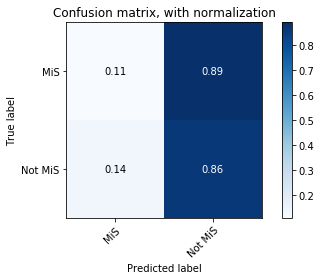

In [476]:
# Plot normalized confusion matrix
plot_confusion_matrix(bin_labels_true, bin_labels_pred, target_names=['MiS', 'Not MiS'], 
                      normalize=True,
                      title='Confusion matrix, with normalization')

Normalized confusion matrix
[[0.38 0.   0.62]
 [0.   0.   1.  ]
 [0.13 0.01 0.86]]


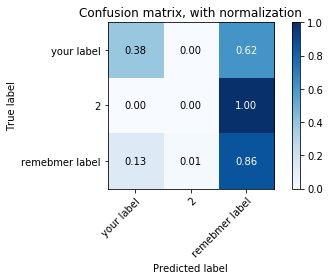

In [477]:
# Plot normalized confusion matrix
plot_confusion_matrix(mult_labels_true.argmax(axis=1), mult_labels_pred.argmax(axis=1), target_names=['your label',2,'remebmer label',4], 
                      normalize=True,
                      title='Confusion matrix, with normalization')

In [478]:
def plot_roc_curve(labels_true, labels_pred, target_names, binary=True):
    
    if binary:
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr, tpr, _ = roc_curve(labels_true, labels_pred)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(target_names, roc_auc))
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for binary data')
        plt.legend(loc="lower right")
        plt.show()
        
    else:  
        # Binarize the output
        labels_true = label_binarize(labels_true, classes=[1, 2,3,4,5,6,7,8,9,10,11,12,99])
        n_classes = np.shape(target_names)[0]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(labels_true[:,i], labels_pred[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        colors = cycle(['blue', 'red', 'green'])
        
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(target_names[i], roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for multi-class data')
        plt.legend(loc="lower right")
        plt.show()

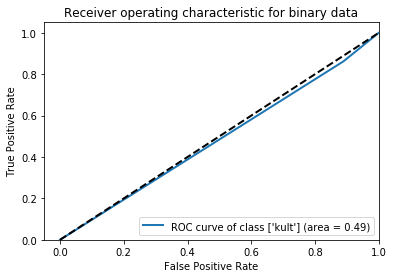

In [479]:
plot_roc_curve(bin_labels_true, bin_labels_pred, target_names=['kult'], binary=True)

/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/sklearn/metrics/ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


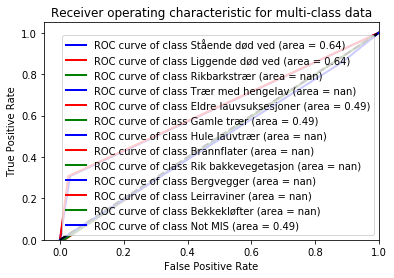

In [480]:
plot_roc_curve(mult_labels_true, mult_labels_pred, target_names=target_names, binary=False)

## Create polygons with predictions as attributes

In [38]:
%time
image_dir_path = '../Sorted_tiles/' 

gdf = geopandas.GeoDataFrame()

for num_tile, tile in labelfile.iterrows():
    
    # Find image path
    tile_path = image_dir_path + tile['Tile_name']
    
    # Open image and find image bounds
    tile_opened = rasterio.open(tile_path)
    tile_bounds = tile_opened.bounds
    
    # Create and store geometry
    tile_bounds_geometry = geopandas.base.box(tile_bounds[0], tile_bounds[1], tile_bounds[2], tile_bounds[3])
    gdf = gdf.append([tile_bounds_geometry])

# Rename geometry colum and create a new index
gdf.columns = ['geometry']
gdf.reset_index(inplace=True, drop=True)

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 22.6 µs


In [39]:
gdf.head()

,geometry
0,"POLYGON ((587171.55 6757675.55, 587171.55 6757..."
1,"POLYGON ((587186.55 6757675.55, 587186.55 6757..."
2,"POLYGON ((587201.55 6757675.55, 587201.55 6757..."
3,"POLYGON ((587216.55 6757675.55, 587216.55 6757..."
4,"POLYGON ((587231.55 6757675.55, 587231.55 6757..."


In [40]:
#predicted_classes_gdf
#result = pd.concat([predicted_classes_gdf, gdf], sort=False)
#result = geopandas.GeoDataFrame( pd.concat( [predicted_classes_gdf, gdf], ignore_index=True,sort=False) )
result = gdf.merge(predicted_classes_gdf, right_index=True, left_index=True)
result

,geometry,1,2,3,4,5,6,7,8,9,10,11,12,99
0,"POLYGON ((587171.55 6757675.55, 587171.55 6757...",1.000000e+00,9.999973e-01,8.162173e-37,1.158336e-36,3.608783e-12,1.002747e-14,6.050426e-38,1.149042e-36,0.000000e+00,2.442116e-36,1.946630e-37,5.873927e-37,1.624186e-18
1,"POLYGON ((587186.55 6757675.55, 587186.55 6757...",2.542185e-01,2.797647e-02,7.857493e-20,3.568477e-18,3.476582e-07,7.447671e-09,1.358159e-21,1.257402e-19,1.744672e-18,3.800708e-20,1.077764e-18,1.971713e-20,1.124803e-05
2,"POLYGON ((587201.55 6757675.55, 587201.55 6757...",9.711591e-01,7.287975e-01,2.066980e-13,6.061306e-12,1.356052e-04,6.346756e-07,4.951065e-13,7.678854e-13,1.076182e-11,1.259556e-13,1.032620e-11,2.764633e-13,1.952389e-05
3,"POLYGON ((587216.55 6757675.55, 587216.55 6757...",9.984022e-01,9.771029e-01,6.167191e-13,4.333043e-12,3.804628e-05,2.334359e-07,1.975848e-12,2.470137e-12,4.943123e-12,3.203276e-13,9.197527e-12,2.046203e-12,5.092845e-06
4,"POLYGON ((587231.55 6757675.55, 587231.55 6757...",1.000000e+00,9.999930e-01,6.949029e-31,8.400631e-31,1.693890e-10,2.876903e-13,1.118516e-31,5.162977e-31,1.001579e-32,1.428974e-30,2.038688e-31,5.724407e-31,6.189773e-16
5,"POLYGON ((587246.55 6757675.55, 587246.55 6757...",1.000000e+00,9.999983e-01,0.000000e+00,0.000000e+00,3.303174e-14,2.894180e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.092036e-21
6,"POLYGON ((587141.55 6757660.55, 587141.55 6757...",1.000000e+00,9.999987e-01,0.000000e+00,0.000000e+00,6.650439e-13,2.002440e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.167746e-20
7,"POLYGON ((587156.55 6757660.55, 587156.55 6757...",9.990575e-01,9.557061e-01,1.484976e-20,2.826582e-19,5.402979e-08,1.351939e-09,7.644608e-22,4.036906e-20,5.229787e-20,9.350846e-21,3.580691e-20,4.046834e-21,1.111041e-07
8,"POLYGON ((587171.55 6757660.55, 587171.55 6757...",2.444094e-05,1.492835e-04,8.135023e-14,2.054059e-12,1.205958e-06,8.545285e-08,1.978997e-16,4.439202e-15,4.961843e-13,9.241863e-15,1.020951e-12,2.146700e-14,2.000470e-01
9,"POLYGON ((587186.55 6757660.55, 587186.55 6757...",9.999961e-01,9.998050e-01,5.765499e-16,1.860939e-14,1.164850e-06,9.732685e-11,4.236567e-13,1.106292e-14,2.028445e-12,3.805024e-16,2.518803e-12,1.012611e-14,1.268387e-07


In [41]:
gdf_test = geopandas.GeoDataFrame(result, geometry='geometry')
gdf_test.crs = {'init' :'epsg:32632'}
type(gdf_test)

geopandas.geodataframe.GeoDataFrame

In [42]:
# Export shapefile
gdf_test.to_file('../Models/simple_model_0504.shp', driver='ESRI Shapefile')

/home/landsat7/anaconda3/envs/master2018/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


## Notes

In [ ]:
create dataframe

for element in list:
    predict tile labels
    store in dataframe
        
    get tile bounds
    convert tilebounds to polygon
    store in dataframe
    
save as shp with correct epsg

In [431]:
import rasterio
sus = '../Sorted_tiles/' + test_image_predict['Tile_name'].item()
raster = rasterio.open(sus)
suli = raster.bounds
uli = raster.xy(25,25)

print(suli)
print(uli)

BoundingBox(left=587336.55, bottom=6757630.55, right=587351.55, top=6757645.55)
(587344.2000000001, 6757637.899999999)


In [460]:
b = geopandas.base.box(suli[0], suli[1], suli[2], suli[3])
#b = geopandas.base.box(suli[0], suli[2], suli[1], suli[3])

d = {'col1': [1], 'col2': [3]}
ddf = pd.DataFrame(data=d)

gdf = geopandas.GeoDataFrame(ddf, geometry=[b])
gdf.head()

,col1,col2,geometry
0,1,3,"POLYGON ((587351.55 6757630.55, 587351.55 6757..."


<Figure size 432x288 with 0 Axes>

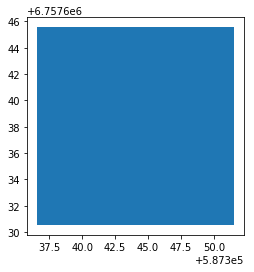

In [453]:
import matplotlib.pyplot as plt
# Plot mis-polygons
plt.figure()
gdf.plot()
plt.show()